In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import nivapy3 as nivapy
import seaborn as sn
import matplotlib.pyplot as plt
import warnings
import toc_trends_analysis as toc_trends

#warnings.filterwarnings("ignore")
plt.style.use('ggplot')

In [2]:
# Connect to NIVABASE
eng = nivapy.da.connect()

Username:  ···
Password:  ········


Connection successful.


# TOC Thematic Report - February 2019 (Part 3: combining "core" and "trends" datasets)

Øyvind's outline for the Thematic Trends Report includes the following:

    Trends in surface water chemistry 1990-2016
    a. General overview of trend analysis (spaghetti plots?)
    
    b. Time series from sites sampled frequently (at least monthly)
      i.   Trends in annual means
      ii.  Trends in severity of episodes
      iii. Trends in climate
      iv.  Search for breaking points (periods of significant change)
       
    c. Regional trends (all sites)

In addition, it has been decided to combine data from the "core" ICPW dataset with that from the expanded "trends" work. This is not straightforward, as there is significant overlap between the two datasets, and in most cases we have mutliple time series for the same site. I would like to move towards using a single "definitive" series for each station, but am reluctant to delete/remove the duplicated series without more thorough checking. In the medium term, I will **preferentially use data from the "trends" stations where possible (this has been more thoroughly checked), and will only use the "core" series for stations that are not part of the trends work**.

As a starting point, I have generated a single Excel listing all the ICPW stations for which we have data of reasonable quality. This dataset comprises **all the "trends" locations**, plus stations from **16 countries in the "core" dataset** (the 15 countries listed [here](https://nbviewer.jupyter.org/github/JamesSample/icpw/blob/master/toc_report_feb_2019_part1.ipynb#2.1.-Select-projects), plus the Netherlands). For the present, this can be taken as a definitve list of stations within the ICPW project.

## 1. Stations

In [3]:
# Read stations
stn_path = r'../../../all_icpw_sites_may_2019.xlsx'
stn_df = pd.read_excel(stn_path, sheet_name='all_icpw_stns')

# Check stn numbners seem OK
trend_df = stn_df.query("group in ('Trends', 'Trends+Core')")
core_df = stn_df.query("group in ('Core', 'Trends+Core')")

print(f'There are {len(stn_df)} unique stations within the ICPW project as a whole.')
print(f'There are {len(core_df)} stations within the ICPW "core" project.')
print(f'There are {len(trend_df)} stations within the ICPW "trends" project.')
print('')
stn_df.head()

There are 556 unique stations within the ICPW project as a whole.
There are 264 stations within the ICPW "core" project.
There are 432 stations within the ICPW "trends" project.



,station_id,station_code,station_name,latitude,longitude,altitude,continent,country,region,group
0,38115,Tr18_CA_DO1,Blue Chalk Lake,45.1999,-78.9432,344.0,North America,Canada,Ont,Trends
1,38116,Tr18_CA_DO2,Chub Lake,45.2138,-78.9836,343.0,North America,Canada,Ont,Trends
2,38117,Tr18_CA_DO3,Crosson Lake,45.0840,-79.0360,371.0,North America,Canada,Ont,Trends
3,38118,Tr18_CA_DO4,Dickie Lake,45.1510,-79.0876,379.0,North America,Canada,Ont,Trends
4,38119,Tr18_CA_DO5,Harp Lake,45.3798,-79.1335,327.0,North America,Canada,Ont,Trends


In [4]:
# Map
nivapy.spatial.quickmap(stn_df, 
                        cluster=True,
                        popup='station_code',
                        aerial_imagery=True)

## 2. Water chemistry

For now, I'll consider the same raw water chemistry parameters as [here](https://nbviewer.jupyter.org/github/JamesSample/icpw/blob/master/toc_report_feb_2019_part1.ipynb#2.3.-Select-parameters), but excluding alkalinity.

In [5]:
# User options
st_dt = '1990-01-01'
end_dt = '2016-12-31'

# Pars of interest
pars = ['TOC', 'EH', 'ESO4', 'ESO4X', 'ENO3', 'ECa_EMg', 'ECaX_EMgX', 'ANC', 'ANCX', 'ALK-E']
par_list = [1, 5, 6, 7, 8, 11, 12, 13, 14, 49, 65] # All raw pars required to calc those above

# Get chem
wc_df, dup_df = nivapy.da.select_resa_water_chemistry(stn_df,
                                                      par_list,
                                                      st_dt,
                                                      end_dt,
                                                      eng,
                                                      drop_dups=True,
                                                      lod_flags=False)

wc_df.head()

WARNING
The database contains unexpected duplicate values for some station-date-parameter combinations.
Only the most recent values will be used, but you should check the repeated values are not errors.
The duplicated entries are returned in a separate dataframe.



,station_id,station_code,station_name,sample_date,depth1,depth2,ALK-E_µEq/l,Ca_mg/l,Cl_mg/l,K_mg/l,Mg_mg/l,NH4-N_µg/l N,NO3-N_µg/l N,Na_mg/l,SO4_mg/l,TOC_mg C/l,pH_
,,,,,,,,,,,,,,,,,
0,23472,CH03,Lago di Tomè,1990-10-08,0.0,0.0,NaN,1.12,0.17,0.20,0.10,20.0,330.0,0.31,2.16,NaN,5.44
1,23472,CH03,Lago di Tomè,1993-08-18,0.0,0.0,0.0,0.86,0.03,0.23,0.05,30.0,490.0,0.29,2.29,NaN,5.44
2,23472,CH03,Lago di Tomè,1995-09-05,0.0,0.0,4.0,1.55,0.16,0.14,0.05,0.0,510.0,0.19,2.24,NaN,5.58
3,23472,CH03,Lago di Tomè,1995-09-15,0.0,0.0,0.0,1.02,0.30,0.26,0.10,0.0,450.0,0.31,2.02,NaN,5.39
4,23472,CH03,Lago di Tomè,1997-08-05,0.0,0.0,1.0,0.92,0.19,0.16,0.09,10.0,330.0,0.29,1.85,NaN,5.68


In [6]:
# Some concentrations are less than 0, which doesn't make sense
# Set back to zero
cols = ['Ca_mg/l', 'Cl_mg/l', 'K_mg/l', 'Mg_mg/l', 'NH4-N_µg/l N', 
        'NO3-N_µg/l N', 'Na_mg/l', 'SO4_mg/l', 'TOC_mg C/l', 'pH_']

for col in cols:
    wc_df[col][wc_df[col]<0] = 0

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [7]:
# Remove units from col names
idx_cols = ['station_id', 'station_code', 'station_name', 'sample_date', 'depth1', 'depth2']
wc_df.columns = idx_cols + [i.split('_')[0] for i in wc_df.columns if i not in idx_cols]

# Values in the raw data equal to exactly zero must be wrong
for col in wc_df.columns:
    if col not in idx_cols:
        wc_df[col] = wc_df[col].replace(0, np.nan)
        
# Convert units and apply sea-salt corrections etc.
wc_df = toc_trends.conv_units_and_correct(wc_df)
wc_df.set_index(idx_cols, inplace=True)
wc_df = wc_df[pars]
wc_df.reset_index(inplace=True)
wc_df.head()

,station_id,station_code,station_name,sample_date,depth1,depth2,TOC,EH,ESO4,ESO4X,ENO3,ECa_EMg,ECaX_EMgX,ANC,ANCX,ALK-E
0,23472,CH03,Lago di Tomè,1990-10-08,0.0,0.0,NaN,3.630781,45.000000,44.499714,23.571429,64.333333,63.201619,10.939799,10.308371,NaN
1,23472,CH03,Lago di Tomè,1993-08-18,0.0,0.0,NaN,3.630781,47.708333,47.620048,35.000000,47.166667,46.966952,-15.749821,-15.861249,NaN
2,23472,CH03,Lago di Tomè,1995-09-05,0.0,0.0,NaN,2.630268,46.666667,46.195810,36.428571,81.666667,80.601524,5.850613,5.256327,4.0
3,23472,CH03,Lago di Tomè,1995-09-15,0.0,0.0,NaN,4.073803,42.083333,41.200476,32.142857,59.333333,57.336190,-3.319358,-4.433644,NaN
4,23472,CH03,Lago di Tomè,1997-08-05,0.0,0.0,NaN,2.089296,38.541667,37.982524,23.571429,53.500000,52.235143,3.383879,2.678165,1.0


For the regions 'SoNord', 'UK-IE-NL' and 'AtlCan', we want to use the **sea-salt corrected** data (`X` suffix). Elsewhere, we will use uncorrected values. 

In [8]:
# Regions to correct
sscor_regs = ['SoNord', 'UK-IE-NL', 'AtlCan']

# Join regions
wc_df = pd.merge(wc_df,
                 stn_df[['station_id', 'region']],
                 how='left',
                 on='station_id')

# Split dataset
sscor_df = wc_df.query("region in @sscor_regs").copy()
nocor_df = wc_df.query("region not in @sscor_regs").copy()

# Get relevant cols for each dataset. Rename Remove 'X' suffix from corrceted data
sscor_cols = ['TOC', 'EH', 'ESO4X', 'ENO3', 'ECaX_EMgX', 'ANCX', 'ALK-E']
nocor_cols = ['TOC', 'EH', 'ESO4', 'ENO3', 'ECa_EMg', 'ANC', 'ALK-E']
nocor_df = nocor_df[idx_cols+nocor_cols]
sscor_df = sscor_df[idx_cols+sscor_cols]
sscor_df.columns = idx_cols+nocor_cols

# Combine
wc_df = pd.concat([nocor_df, sscor_df], 
                  axis=0, 
                  sort=False).reset_index(drop=True)

wc_df.head()

,station_id,station_code,station_name,sample_date,depth1,depth2,TOC,EH,ESO4,ENO3,ECa_EMg,ANC,ALK-E
0,23472,CH03,Lago di Tomè,1990-10-08,0.0,0.0,NaN,3.630781,45.000000,23.571429,64.333333,10.939799,NaN
1,23472,CH03,Lago di Tomè,1993-08-18,0.0,0.0,NaN,3.630781,47.708333,35.000000,47.166667,-15.749821,NaN
2,23472,CH03,Lago di Tomè,1995-09-05,0.0,0.0,NaN,2.630268,46.666667,36.428571,81.666667,5.850613,4.0
3,23472,CH03,Lago di Tomè,1995-09-15,0.0,0.0,NaN,4.073803,42.083333,32.142857,59.333333,-3.319358,NaN
4,23472,CH03,Lago di Tomè,1997-08-05,0.0,0.0,NaN,2.089296,38.541667,23.571429,53.500000,3.383879,1.0


For some locations - most notably Ireland - the sea-salt correction produces negative values for some parameters. We have discussed this fairly extensively (see e.g. [here](https://nbviewer.jupyter.org/github/JamesSample/icpw/blob/master/ireland_seasalt_correction.ipynb?flush_cache=true) and the e-mail received from Øyvind on 24.06.2019 at 13.44). Our current decision is to accept these negative values as indicating high uncertainty, but still reflecting our "best guess" from which to base the trend analyses. The code cell below is therefore commented out.

In [9]:
# TOC, EH, ESO4X, ENO3 and ECaX_EMgX should be positive
# Set values < 0 to zero
#for col in ['TOC', 'EH', 'ESO4', 'ENO3', 'ECaX_EMg']:
#    wc_df[col][wc_df[col] < 0] = 0    

## 3. Basic quality checking

In [10]:
# In the past, some German stations have reported depths > 0. Remove these
wc_df = wc_df.query("(depth1 == 0) and (depth2 == 0)")

In [11]:
# Save for speed
wc_csv = r'../../../Thematic_Trends_Report_2019/working_chem.csv'
wc_df.to_csv(wc_csv, 
             index=False, 
             encoding='utf-8')

In [12]:
# Load saved data
wc_csv = r'../../../Thematic_Trends_Report_2019/working_chem.csv'
wc_df = pd.read_csv(wc_csv, encoding='utf-8')
wc_df['sample_date'] = pd.to_datetime(wc_df['sample_date'])

In [13]:
# Which stations have duplicates?
dup_df['station_code'].unique()

array(['DE02', 'DE03', 'DE04', 'DE07', 'DE08', 'DE09', 'DE13', 'DE14',
       'DE16', 'DE18', 'DE19', 'DE20', 'DE21', 'DE25', 'DE28', 'DE29',
       'DE30', 'DE31', 'DE32', 'DE33', 'DE34', 'DE36', 'EE01', 'LV03',
       'LV04', 'LV05', 'LV07', 'LV08'], dtype=object)

As described [here](https://nbviewer.jupyter.org/github/JamesSample/icpw/blob/master/toc_report_feb_2019_part1.ipynb#2.5.1.-Duplicates), these duplicates are due to some countries reporting both DOC and TOC, which are not distinguished within ICPW.

In [14]:
# How many stations have data?
print(len(stn_df), 'stations in total.')
print(len(wc_df['station_id'].unique()), 'stations with data.')

# Identify stns missing data
print('\nStations without data:')
no_data_stns = set(stn_df['station_id']) - set(wc_df['station_id'])

stn_df.query('station_id in @no_data_stns')

556 stations in total.
549 stations with data.

Stations without data:


,station_id,station_code,station_name,latitude,longitude,altitude,continent,country,region,group
204,38562,IE20,"Clare, Naminna, Mid Lake",52.78408,-9.22064,NaN,Europe,Ireland,UK-IE-NL,Core
212,38547,IT07,Lake Capezzone,45.93820,8.20948,2100.0,Europe,Italy,Alps,Core
213,38548,IT08,Lake Grande,46.00131,8.07820,2269.0,Europe,Italy,Alps,Core
214,38549,IT09,Lake Variola Superiore,46.17569,8.44098,2190.0,Europe,Italy,Alps,Core
215,38550,IT10,Lake Variola Inferiore lungo,46.17569,8.21690,2117.0,Europe,Italy,Alps,Core
216,38551,IT11,Lake Gelato,46.24860,8.44098,2087.0,Europe,Italy,Alps,Core
217,38552,IT12,Lake Muino Superiore,46.18070,8.48950,1960.0,Europe,Italy,Alps,Core


This makes sense: IE20 has no data for the reasons described [here](https://nbviewer.jupyter.org/github/JamesSample/icpw/blob/master/toc_report_feb_2019_part1.ipynb#2.5.2.-Number-of-stations-with-data). The six Italian stations were proposed in 2018 and monitoring did not begin until 2017, so they are not relevant here.

## 4. Distribution of data through time

The plots below show the **median number of samples per year** for each country. Error bars show the 95% confidence interval around this median.

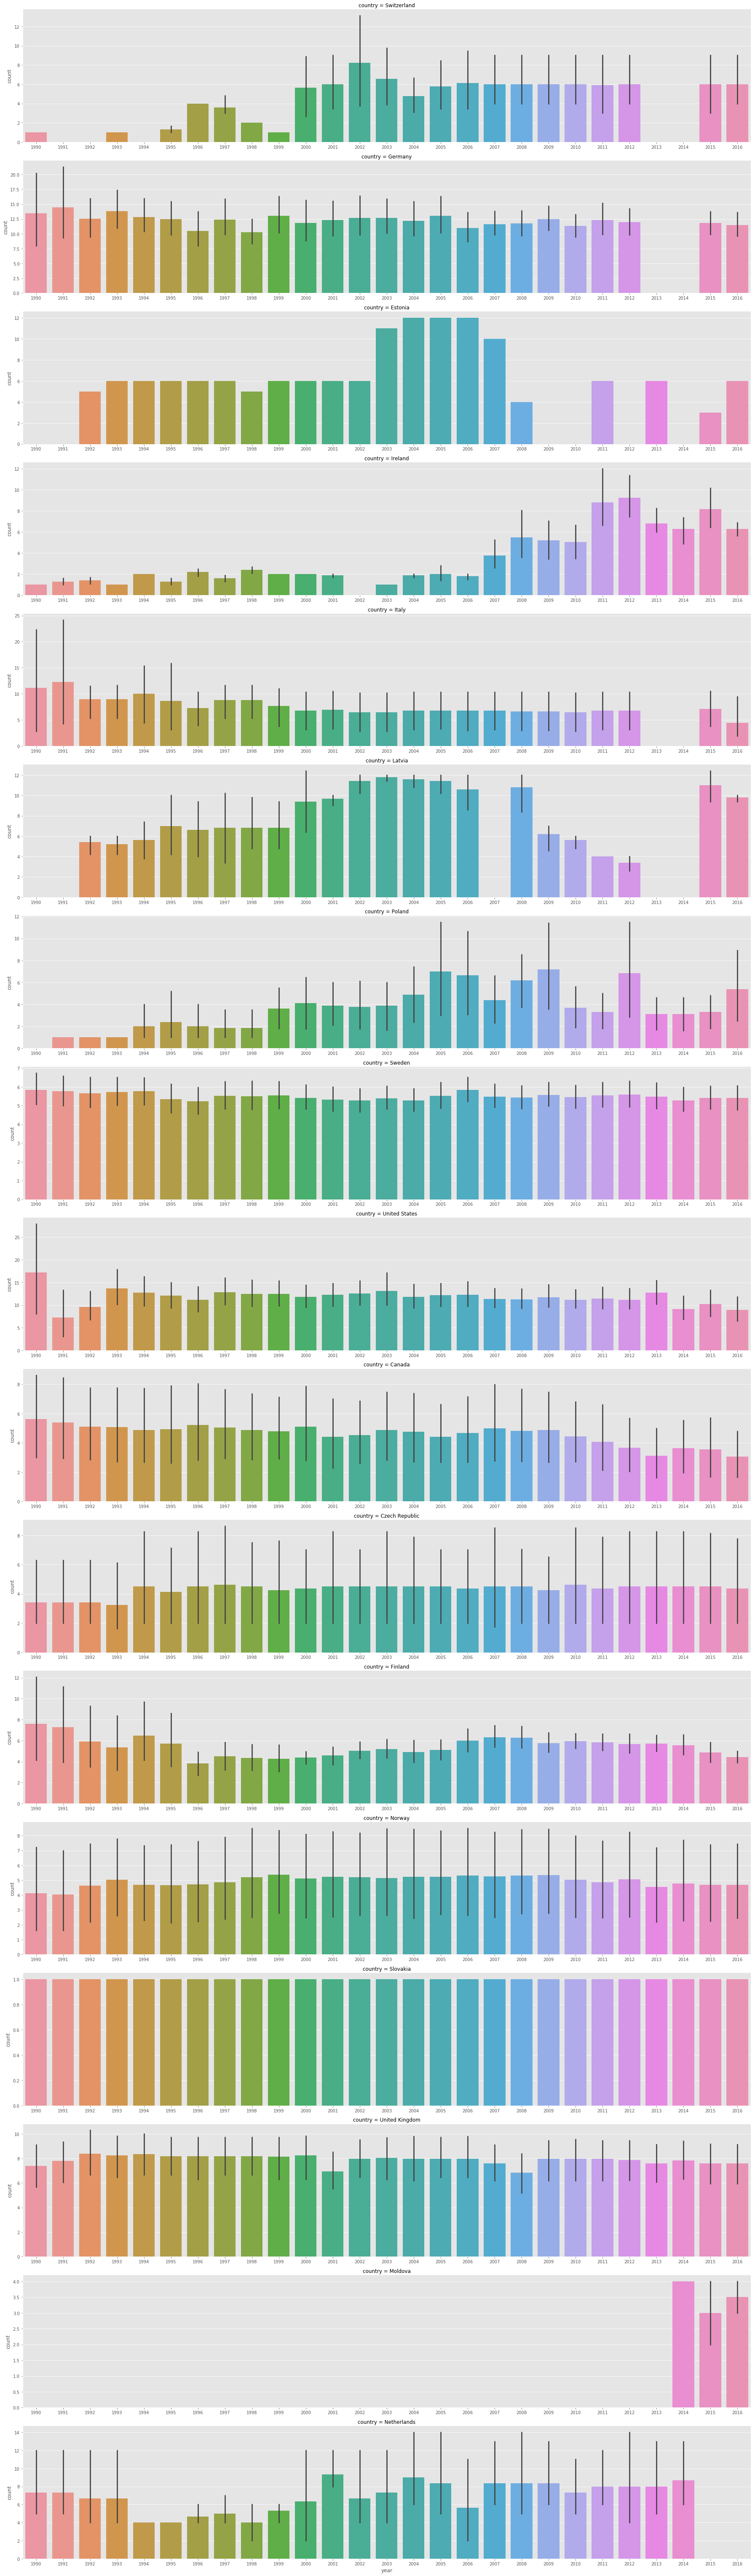

In [15]:
# Extract year
wc_df2 = pd.merge(wc_df, 
                  stn_df[['station_id', 'country']],
                  how='left', 
                  on='station_id')

wc_df2['year'] = wc_df2['sample_date'].dt.year

# Number of samples per year per site
agg = wc_df2.groupby(['station_id', 'country', 'year']).agg({'station_code':'count'}).reset_index()
agg.columns = ['station_id', 'country', 'year', 'count']

# Plot
g = sn.catplot(data=agg, 
               x='year', 
               y='count', 
               row='country', 
               kind='bar',
               ci=95,
               sharey=False,
               aspect=5)

for ax in g.axes:
    ax[0].xaxis.set_tick_params(which='both', labelbottom=True)    
plt.tight_layout()

In [16]:
# Get the min, med and max samples per year for each country
agg.groupby('country').agg({'count': ['min', 'median', 'max']})

count            
                 min median  max
country                         
Canada             1      2   82
Czech Republic     1      2   13
Estonia            3      6   12
Finland            1      6   38
Germany            1     12   79
Ireland            1      2   21
Italy              1     10   40
Latvia             2      7   13
Moldova            2      4    4
Netherlands        2      6   14
Norway             1      1   59
Poland             1      1   24
Slovakia           1      1    1
Sweden             1      4   19
Switzerland        1      3   18
United Kingdom     3      7   16
United States      1     12  103

## 5. Identify high-frequency monitoring

Stations in Canada, the USA and Norway have 25 samples per year for all years. These can support more detailed analysis.

In [17]:
# At least 25 samples per year
hi_freq_df = stn_df[stn_df['station_id'].isin(agg.groupby('station_id').agg({'count':'min'}).query("count > 25").index)]
out_csv = r'../../../Thematic_Trends_Report_2019/hi_freq_stns.csv'
hi_freq_df.to_csv(out_csv, index=False, encoding='utf-8')
hi_freq_df

,station_id,station_code,station_name,latitude,longitude,altitude,continent,country,region,group
8,38085,Tr18_CA01,"Ontario, Algoma Region, Batchawana Lake",47.060000,-84.393000,497.0,North America,Canada,Ont,Trends+Core
9,38086,Tr18_CA02,"Ontario, Algoma Region, Wishart Lake",47.041000,-84.402000,388.0,North America,Canada,Ont,Trends+Core
10,38087,Tr18_CA03,"Ontario, Algoma Region, Little Turkey Lake",47.041000,-84.406000,375.0,North America,Canada,Ont,Trends+Core
11,38088,Tr18_CA04,"Ontario, Algoma Region, Turkey Lake",47.050000,-84.408000,372.0,North America,Canada,Ont,Trends+Core
307,38312,Tr18_NO_BIE01,Birkenes,58.385426,8.241721,190.0,Europe,Norway,SoNord,Trends+Core
310,38242,Tr18_NO_LAE01,"Langtjern, utløp",60.372460,9.726660,516.0,Europe,Norway,SoNord,Trends+Core
312,38314,Tr18_NO_STE01,Storgama v. dam,59.052333,8.653606,587.0,Europe,Norway,SoNord,Trends+Core
394,38316,Tr18_NO_DALELV,Dalelv,69.684738,30.386154,10.0,Europe,Norway,NoNord,Trends+Core
464,38470,Tr18_US_01434025,"Biscuit Brook, Catskills",42.011100,-74.414700,634.0,North America,United States,AdsCsk,Trends+Core
538,23623,US104,"Piney River, Virginia",38.703000,-78.268700,360.0,North America,United States,BRM,Core


## 6. Parameter distributions

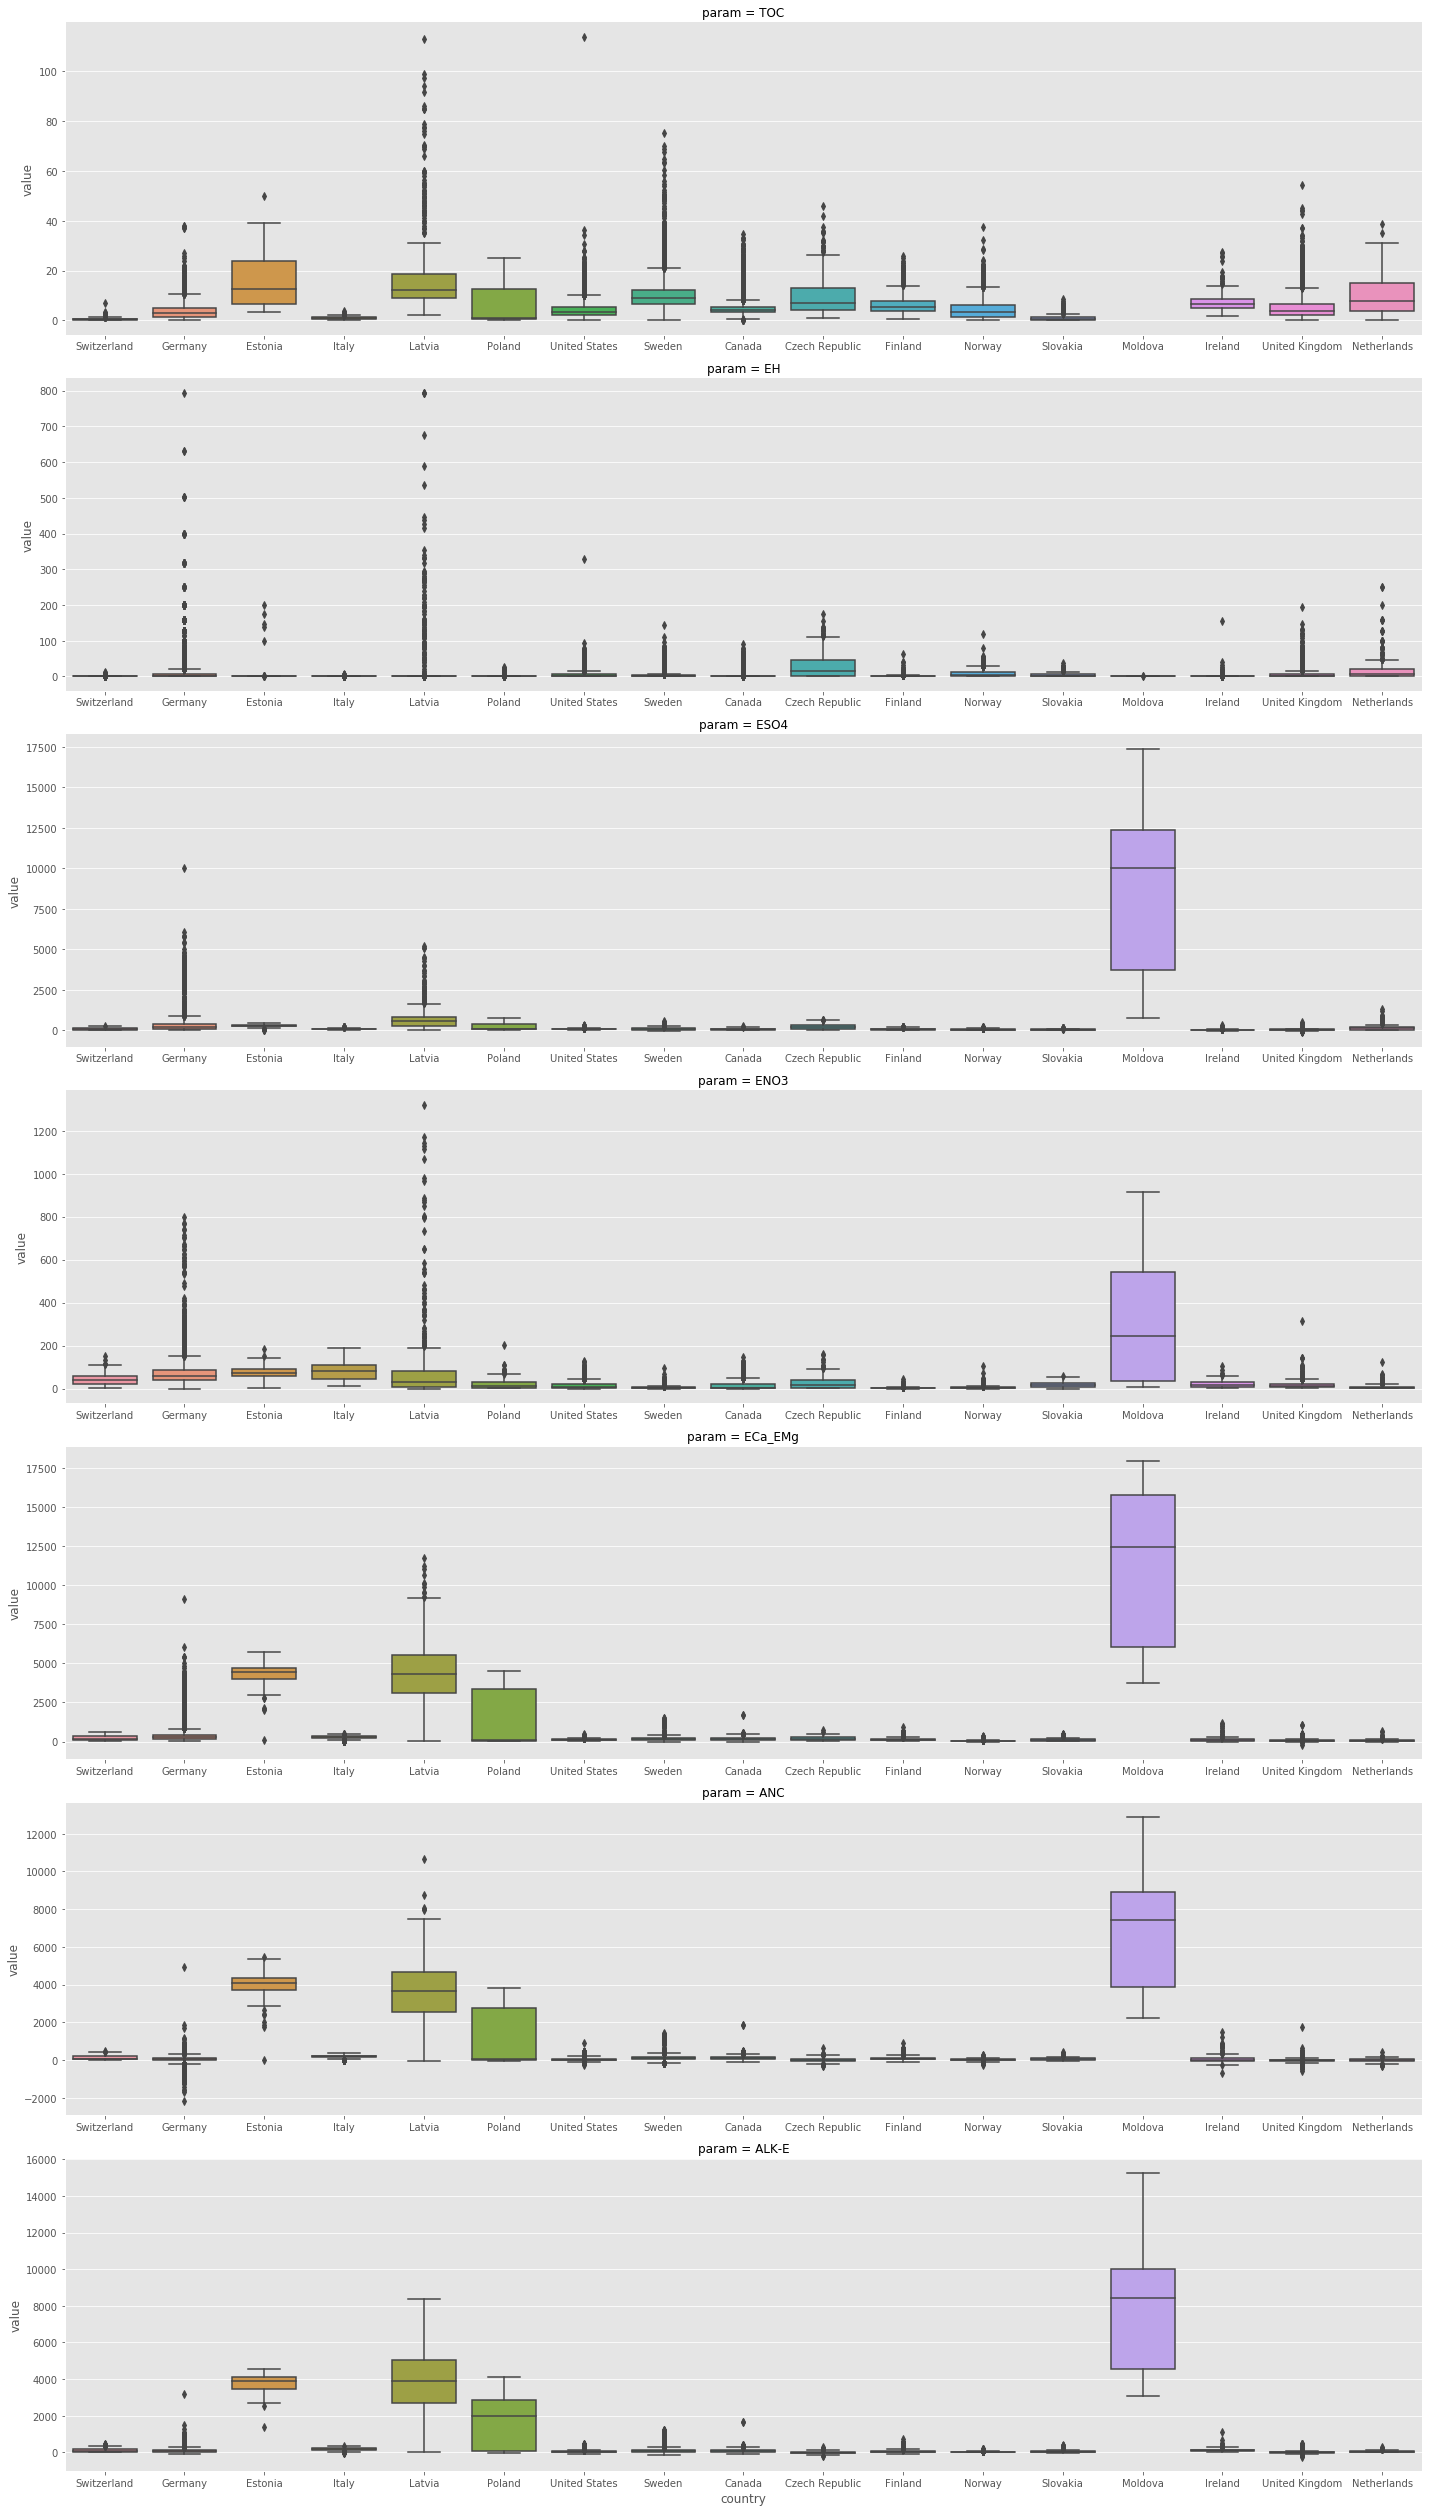

In [18]:
# Melt to long format
wc_lng = wc_df2.melt(id_vars=['station_id', 'station_code', 
                              'station_name', 'country', 
                              'sample_date', 'year', 
                              'depth1', 'depth2'],
                     var_name='param')

# Plot
g = sn.catplot(data=wc_lng,
               x='country',
               y='value',
               row='param',
               kind='box',
               aspect=4,
               sharey=False)

for ax in g.axes:
    ax[0].xaxis.set_tick_params(which='both', labelbottom=True)    
plt.tight_layout()

In [19]:
# Summary stats for df
wc_df.describe()

,station_id,depth1,depth2,TOC,EH,ESO4,ENO3,ECa_EMg,ANC,ALK-E
count,89422.000000,89422.0,89422.0,76584.000000,88018.000000,86497.000000,84110.000000,86252.000000,79365.000000,76016.000000
mean,34878.635828,0.0,0.0,5.575895,5.974365,109.595300,17.718311,219.561316,120.534988,119.042848
std,6181.262159,0.0,0.0,4.881872,17.203128,280.127023,34.896485,582.209063,474.618816,487.388714
min,23472.000000,0.0,0.0,0.005000,0.000030,-135.096667,0.002861,-188.480000,-2142.606307,-227.000000
25%,36463.000000,0.0,0.0,2.600000,0.247885,41.077794,1.428571,67.464065,8.075219,8.990000
50%,38252.000000,0.0,0.0,4.277500,0.812831,70.347599,6.000000,124.385802,51.076414,40.012500
75%,38433.000000,0.0,0.0,7.110000,5.308844,105.151148,20.600000,211.000000,123.876709,100.000000
max,38607.000000,0.0,0.0,113.990000,794.328235,17395.833333,1321.428571,17950.000000,12901.405479,15260.000000


In [31]:
# Check regions with negative values
for col in ['TOC', 'EH', 'ESO4', 'ENO3', 'ECa_EMg', 'ANC', 'ALK-E']:
    if wc_df[col].min() < 0:
        stn_ids = wc_df[wc_df[col]<0]['station_id'].unique()
        print('%s is less than zero in the following regions:' % col)
        print('    ', stn_df.query('station_id in @stn_ids')['region'].unique())

ESO4 is less than zero in the following regions:
     ['AtlCan' 'UK-IE-NL' 'SoNord']
ECa_EMg is less than zero in the following regions:
     ['AtlCan' 'UK-IE-NL' 'SoNord']
ANC is less than zero in the following regions:
     ['Ont' 'QuMaVt' 'AtlCan' 'ECE' 'SoNord' 'NoNord' 'WCE' 'UK-IE-NL' 'Alps'
 'Baltic' 'AdsCsk' 'BRM' 'Apps']
ALK-E is less than zero in the following regions:
     ['QuMaVt' 'AtlCan' 'ECE' 'SoNord' 'NoNord' 'WCE' 'Alps' 'UK-IE-NL'
 'AdsCsk' 'BRM' 'Apps']


ANC and alkalinity can both be negative, so the above output looks OK. We only have negative ESO4 and ECa_EMg in regions where sea-salt corrections have been applied, as described above. 